<a href="https://colab.research.google.com/github/Iamsdt/UdacityPyTorch/blob/master/src/notebook/lesson6/StyleTransfer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

# Import

In [0]:
import torch
from torchvision import models, transforms
import torch.optim as optim

#numpy
import numpy as np
#plot
%matplotlib inline
import matplotlib.pyplot as plt

#image
from PIL import Image

# Load Models

In [3]:
vgg=models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:07<00:00, 75535693.26it/s]


In [5]:
# we need only features
vgg=vgg.features
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [0]:
#freeze all VGG parameters since we're only optimizing the target image
for parm in vgg.parameters():
  parm.requires_grad_(False)

In [96]:
# move to GPU
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

# Load Images

In [0]:
#helper function
def load_image(path,max_size=400,shape=None):
  ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
  
  #open the image and convert to rgb
  img = Image.open(path).convert("RGB")
  
  # large images will slow down processing
  m = max(img.size)
  if m > max_size:
      size = max_size
  else:
      size = m
  
  if shape is not None:
    size = shape
  
  in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
  img = in_transform(img).unsqueeze(0)
  return img

In [0]:
path='dev.png'

In [0]:
# normolize tensor to numpy
def im_convert(tensor):
  #move tensor to cpu
  image=tensor.to('cpu').clone().detach()
  #convert tensor to numpy
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  #std and mean
  std=np.array((0.229, 0.224, 0.225))
  mean=np.array((0.485, 0.456, 0.406))
  #unnormolize
  image=image*std+mean
  #clip
  image=image.clip(0,1)
  return image

In [0]:
#load image and move to GPU
content=load_image(path).to(device)
style=load_image("hockney.jpg").to(device)

Show image

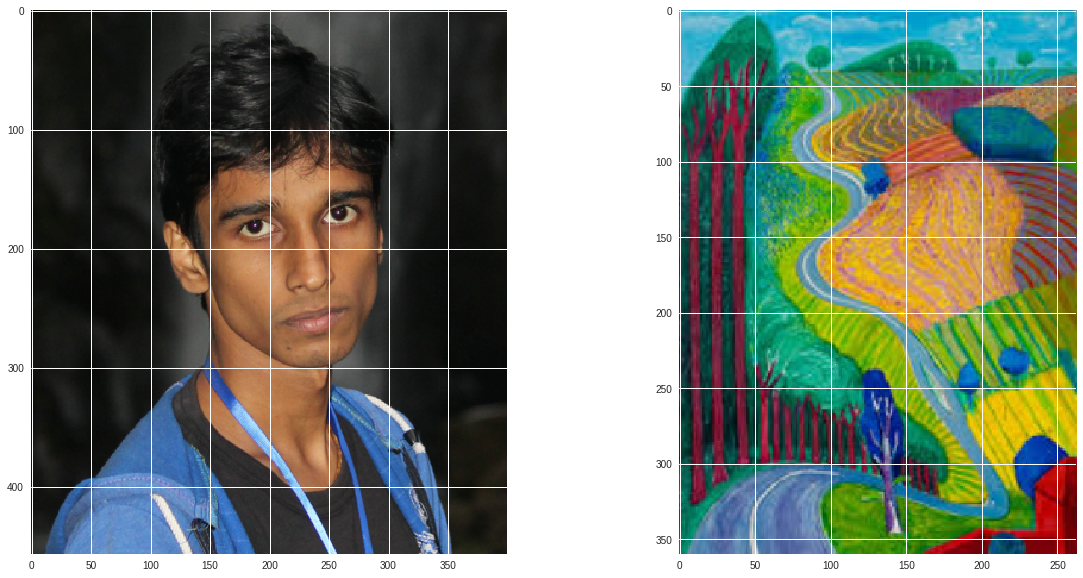

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

# Features

In [0]:
def get_features(image,model,layers=None):
  #fill the layers
  if layers is None:
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  ## content representation
              '28': 'conv5_1'}

  features = {}
  #save image
  x = image
  
  for name,layer in vgg._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]]=x
    
  return features

In [0]:
def gram_matrix(tensor):
  # get the batch_size, depth, height, and width of the Tensor
  _, d, h, w = tensor.size()
  # reshape so we're multiplying the features for each channel
  tensor = tensor.view(d, w * h)
  #calculate the gram matrix
  gram = torch.mm(tensor, tensor.t())
  
  return gram

In [0]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

View target image

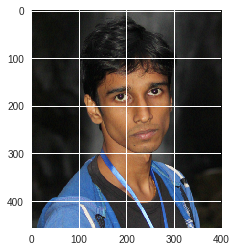

In [91]:
plt.imshow(im_convert(target))

# Loss and Weights

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.5,
                 'conv4_1': 0.25,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

# Updating the Target 

Total loss:  3041846.0


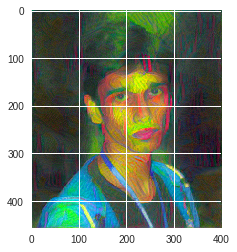

Total loss:  2474385.5


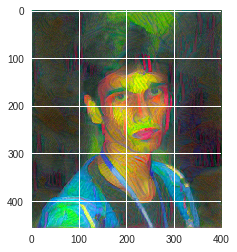

Total loss:  2186398.25


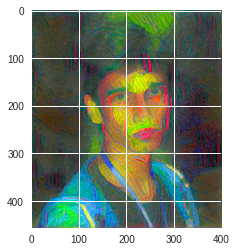

Total loss:  2298190.25


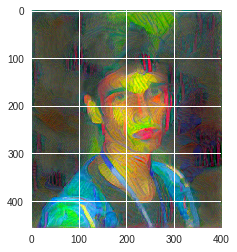

In [109]:
# for displaying the target image, intermittently
show_every = 300
#optimizer
optimizer = optim.Adam([target], lr=0.03)
epochs = 1200

for epoch in range(0,epochs+1):
  #get the target feature
  target_features = get_features(target,vgg)
  # the content loss
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  
  #style loss
  style_loss = 0
  for layer in style_weights:
    # get the "target" style representation for the layer
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    
    # get the "style" style representation
    style_gram = style_grams[layer]
    # the style loss for one layer, weighted appropriately
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    # add to the style loss
    style_loss += layer_style_loss / (d * h * w)

  # calculate the *total* loss
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  # update your target image
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  # display intermediate images and print the loss
  if  epoch % show_every == 0:
    print('Total loss: ', total_loss.item())
    plt.imshow(im_convert(target))
    plt.show()
    

# Final Image

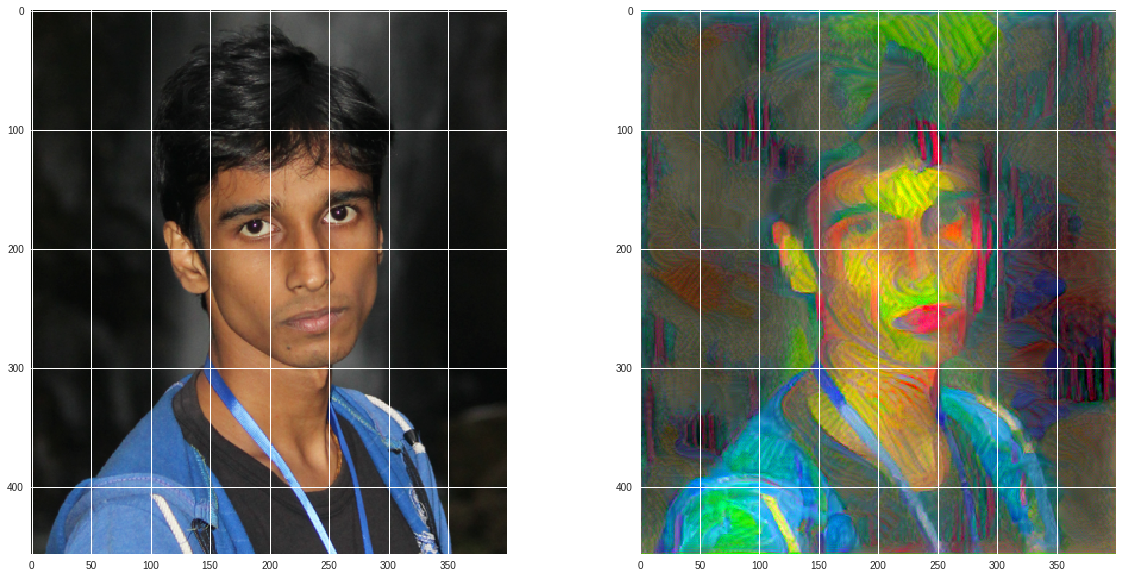

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

# Export 
as picture(png/jpeg)

In [111]:
import imageio
img=im_convert(target)
imageio.imwrite('dev_style.png', img)